In [1]:
# Check GPU
!nvidia-smi

Thu Jun 20 10:29:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P8             10W /  285W |     551MiB /  12282MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
!pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-_n9y13s_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-_n9y13s_
  Resolved https://github.com/huggingface/diffusers.git to commit 668e34c6e0019b29c887bcc401c143a7d088cb25
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-py3-none-any.whl size=2228478 sha256=228587b86ee28bf4706bd5d011ca08aad3e09748cdf436a0e117825f2e18fd20
  Stored in directory: /tmp/pip-ephem-wheel-cache-kxnv9t98/wheels/3a/75/ac/2724a3c688984d6b999006bb9f6b10275f59cf50377b74c585
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.29.0
    Uninstalling diffusers-0.29.0:
      Successfully uninstalled diffusers-0.29.0


In [12]:
!pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-dlu5bewj
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-dlu5bewj
  Resolved https://github.com/huggingface/diffusers.git to commit 668e34c6e0019b29c887bcc401c143a7d088cb25
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
import os

# pick a name for the image folder
item = 'clock'
model = "stabilityai/stable-diffusion-xl-base-1.0"
instance_dir = f"/home/marco/Desktop/ARvertise/code/diffusers/examples/dreambooth/images/tuning_images/dreambooth_dataset/{item}/"
img_extension = 'jpg'
output_dir = f'dreambooth_sdxl/{item}'
instance_prompt = f"photo of a sks {item}"
ckpt_path = f'{output_dir}/dreambooth_{item}.safetensors'
fp16 = True

os.makedirs(output_dir, exist_ok=True)
!rm -rf $instance_dir/.ipynb_checkpoints
!rm -rf output_dir

In [7]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

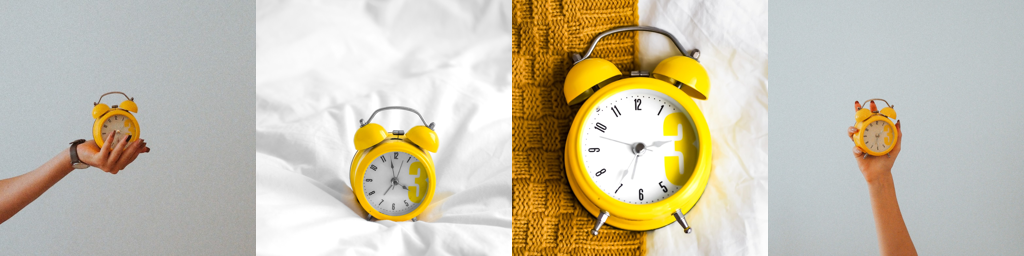

In [8]:
import glob

# change path to display images from your local dir
img_paths = f"{instance_dir}*.{img_extension}"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 4
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [14]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --pretrained_model_name_or_path=$model \
  --instance_data_dir=$instance_dir \
  --output_dir=$output_dir \
  --instance_prompt="$instance_prompt" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=400 \
  --seed="0"

/home/marco/anaconda3/envs/dreambooth/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
06/20/2024 10:34:32 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

/home/marco/anaconda3/envs/dreambooth/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are usi

In [ ]:
import torch
from diffusers import StableDiffusionXLInpaintPipeline, DiffusionPipeline, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image


vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", vae=vae, torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.load_lora_weights(output_dir)
pipe.to("cuda")

init_image = Image.open('/home/marco/Desktop/ARvertise/code/diffusers/examples/dreambooth/images/tuning_images/angry_bird_speaker_inpaint/angry_bird_speaker_3.jpg').convert("RGB")
mask_image = Image.open('/home/marco/Desktop/ARvertise/code/diffusers/examples/dreambooth/images/tuning_images/angry_bird_speaker_inpaint/angry_bird_speaker_mask_4.png').convert("RGB")  #load_image(mask_url).convert("RGB")

prompt = ["A sks bracelet on the wrist of a woman, pleasant to see, high-end, chic, well-designed, crystal clear, beautiful"] * 4
images = pipe(prompt=prompt, image=init_image, mask_image=mask_image, num_inference_steps=40, strength=0.5).images
image_grid(images, 1, 4)